In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
import itertools
import random
#import warnings
#warnings.filterwarnings('ignore')
from pyeasyga import pyeasyga

In [2]:
def hill_activation(x, K, n, ymin, ymax):
    return  ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

In [3]:
fluos = pd.read_csv('datasets/induction_matrix_and/induction_fluos.csv', index_col='time')
ods = pd.read_csv('datasets/induction_matrix_and/induction_ods.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1', 'e16x30SspGyrB', 'e32x33NrdJ1']
controls = ['positive_control', 'negative_control']

In [4]:
#both latest ara and cuma data
hill_params = {'e11x32STPhoRadA': [2.36766927e-02, 1.00000000e+03, 4.00000000e+00, 1.44153218e-01,
        4.85020662e-35, 1.05460242e-03, 6.03613733e+00, 1.56850653e+00],
 'e15x32NpuSspS2': [2.92755784e-02, 9.56644812e+00, 3.19925784e+00, 4.73602217e-01,
        6.43583962e-15, 1.21508540e-03, 1.08890566e+00, 1.08890566e+00],
 'e16x33NrdA2': [3.13214865e-02, 1.00000000e+03, 4.00000000e+00, 3.26516831e-01,
        6.00075781e-39, 1.03610762e-03, 6.61478933e+00, 3.36137478e+00],
 'e20x32gp411': [3.87095907e-02, 2.87402515e-02, 3.21473595e+00, 1.10916549e+00,
        5.89561838e-35, 5.50018830e-03, 4.29512074e+00, 6.08724702e-01],
 'e32x30SspGyrB': [3.38882129e-02, 1.00000000e+03, 3.54036286e+00, 4.31880965e-01,
        2.64511978e-37, 1.03106627e-02, 6.18377096e+00, 4.42459651e+00],
 'e34x30MjaKlbA': [2.49883923e-02, 3.19177623e+01, 4.00000000e+00, 1.44104721e+00,
        1.20619143e-33, 1.17478406e-02, 3.24902918e+00, 3.24902918e+00],
 'e38x32gp418': [2.49200384e-02, 1.00000000e+03, 4.00000000e+00, 1.14015854e-01,
        1.19362000e-38, 1.20615103e-02, 2.30753701e+00, 1.57459945e+00],
 'e41x32NrdJ1': [2.98530663e-02, 1.93409482e+02, 4.00000000e+00, 5.80382417e-01,
        1.38019589e-27, 8.69390911e-03, 3.52150568e+00, 3.52150568e+00],
 'e42x32STIMPDH1': [3.37403314e-02, 8.35596420e+02, 4.00000000e+00, 2.65772483e-01,
        1.22742612e-40, 2.97909555e-03, 2.34091743e+00, 2.34091743e+00],
 'e16x30SspGyrB': [2.98281945e-01, 1.72388881e+02, 2.11909646e+00, 5.50020573e-01,
        5.40857457e-03, 5.40857457e-03, 2.76557347e+00, 2.76557347e+00],
 'e32x33NrdJ1': [3.33691559e-01, 1.64615393e+02, 1.41440908e+00, 6.05984363e-01,
        7.78307072e-03, 7.78307072e-03, 2.97510077e+00, 2.97510077e+00]}

In [5]:
#ara, ohc14, cuma, ahl, dapg, sal, rha, ara
inducers = [
    [0.04793923900410442, 0.04793923904058286, 0.04793924056621433, 0.0479393058980677, 0.04794210359228194, 0.048061907897102074, 0.0531906683345503, 0.26992573739385434, 6.1761811207534105, 16.23080031972892, 16.87552794188468, 16.891198041345216],
    [1.365845205649679e-12, 1.477809602543448e-08, 2.0126270200342847e-07, 2.7412100433656457e-06, 3.733535555988354e-05, 0.0005084518764194502, 0.0069138207147784935, 0.09210718741881846, 0.9665193941238823, 3.1899661887779125, 3.8382539899376513, 3.8963923018006925],
    [3.575023694350424e-27, 0.015516608586247045, 0.03350318091899451, 0.07165827267981141, 0.15026467493653695, 0.302879007101705, 0.5677451197898489, 0.9489157692128366, 1.3720392703934798, 1.7254466182928356, 1.9569898978633842, 2.085543568949304],
    [2.9144583244448006e-14, 0.016371822448534235, 0.040914484578614636, 0.10129783845740496, 0.24851484541441368, 0.5938269471580947, 1.3351050307360446, 2.6617291185039744, 4.42741186589367, 6.022366723674042, 7.0361136783311125, 7.543994698752634],
    [0.04793923900410442, 0.04793923904058286, 0.04793924056621433, 0.0479393058980677, 0.04794210359228194, 0.048061907897102074, 0.0531906683345503, 0.26992573739385434, 6.1761811207534105, 16.23080031972892, 16.87552794188468, 16.891198041345216],
    [1.8474063001429318e-17, 0.021875582902283607, 0.05062636029349429, 0.11662623217219029, 0.26586718539192944, 0.5921268964337124, 1.2555468238624077, 2.42583007362859, 4.052115564797809, 5.696489596328492, 6.902604441331279, 7.5950206097534565],
    [0.1215231788079449, 0.12152431639173153, 0.12153091685855633, 0.12157581426597619, 0.12188120612820852, 0.12395814087935805, 0.13806748859324755, 0.2332006140108892, 0.8436365830294862, 3.7977990503718893, 9.345042598779557, 11.974360213828955],
    [0.04793923900410442, 0.04793923904058286, 0.04793924056621433, 0.0479393058980677, 0.04794210359228194, 0.048061907897102074, 0.0531906683345503, 0.26992573739385434, 6.1761811207534105, 16.23080031972892, 16.87552794188468, 16.891198041345216]
]

In [6]:
class Sensor:
    
    def __init__(self, name, y):
        
        self.name = name
        self.y = y

class Gate:
    
    def __init__(self, name, gate_type, hill_params):
        
        #metadata
        self.name = name
        self.gate_type = gate_type
        
        #parameters
        self.K1 = hill_params[0]
        self.K2 = hill_params[1]
        self.n1 = hill_params[2]
        self.n2 = hill_params[3]
        self.ymin1 = hill_params[4]
        self.ymin2 = hill_params[5]
        self.ymax1 = hill_params[6]
        self.ymax2 = hill_params[7]
        
        #input/output
        self.x = []
        self.y = 0
        
    def assign_input(self, gate):

        self.x.append(gate)

    def assign_output(self, value):

        self.y = value

class Circuit:

    def __init__(self, design, inducers, hill_params):

        #list of connected components
        self.components = []
        self.indexing = {}

        #sensors
        for i, sensor_name in enumerate(design['sensors']):
            self.components.append(Sensor(sensor_name, inducers[i]))
            self.indexing[sensor_name] = i
            
        #gates
        for i, gate_name in enumerate(design['gates']):
            gate_name = gate_name.replace(' ', '')
            gate_type = gate_name.split('(')[0]
            signals = gate_name.split('(')[1].split(')')[0].split(',')
            
            gate = Gate(signals[0], gate_type, hill_params[signals[0]])
            for j in range(1, len(signals)):
                gate.assign_input(self.components[self.indexing[signals[j]]])
            
            self.components.append(gate)
            self.indexing[signals[0]] = i+len(design['sensors'])
            
    def signal_match(self):
        
        for g in self.components:
            if isinstance(g, Gate):
                g.y = hill_activation_and((g.x[0].y, g.x[1].y), g.K1, g.K2, g.n1, g.n2, g.ymin1, g.ymin2, g.ymax1, g.ymax2)
            
    def print_design(self):
        
        print([component.name for component in self.components])
        print([(i, component.y) for i, component in enumerate(self.components)])
        
    def get_output(self):
        return self.components[-1].y

#### Circuit design

In [58]:
#4 INPUTS -> how to make this more generic?
def circuit_designer(gates):
    
    return {
        'name': 'circuit1',
        'sensors': ['sensor_{}'.format(i) for i in range(4)], #--> sensor name does not really matter
        'gates': [
            'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
            'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
            'AND({},{},{})'.format(gates[2], gates[0], gates[1])
        ]
    }

selected_gates = ['e11x32STPhoRadA', 'e20x32gp411', 'e34x30MjaKlbA']
circuit_example = circuit_designer(selected_gates)

In [57]:
aras_rpu = inducers[0]
cumas_rpu = inducers[2]
circuit = Circuit(circuit_example, [aras_rpu[-1], cumas_rpu[-1], aras_rpu[-1], cumas_rpu[-1]], hill_params)
circuit.signal_match()
circuit.print_design()

['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'e11x32STPhoRadA', 'e20x32gp411', 'e34x30MjaKlbA']
[(0, 16.891198041345216), (1, 2.085543568949304), (2, 16.891198041345216), (3, 2.085543568949304), (4, 2.7610139914367844), (5, 2.592371000003551), (6, 0.31308939967636246)]


In [61]:
# 8 INPUTS -> how to make this more generic?
def circuit_designer(gates):
     return {
        'name': 'circuit2',
        'sensors': ['sensor_{}'.format(i) for i in range(8)],
        'gates': [
            'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
            'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
            'AND({},{},{})'.format(gates[2], 'sensor_4', 'sensor_5'),
            'AND({},{},{})'.format(gates[3], 'sensor_6', 'sensor_7'),
            'AND({},{},{})'.format(gates[4], gates[0], gates[1]),
            'AND({},{},{})'.format(gates[5], gates[2], gates[3]),
            'AND({},{},{})'.format(gates[6], gates[4], gates[5])
        ]
     }

selected_gates = ['e16x33NrdA2', 'e41x32NrdJ1', 'e32x30SspGyrB', 'e42x32STIMPDH1', 
                  'e11x32STPhoRadA', 'e38x32gp418', 'e20x32gp411']
circuit_example = circuit_designer(selected_gates)

In [63]:
circuit = Circuit(circuit_example, [inducers[0][-1], inducers[2][-1], inducers[0][-1], inducers[2][-1], inducers[0][-1], inducers[2][-1], inducers[0][-1], inducers[2][0]], hill_params)
circuit.signal_match()
circuit.print_design()

['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'e16x33NrdA2', 'e41x32NrdJ1', 'e32x30SspGyrB', 'e42x32STIMPDH1', 'e11x32STPhoRadA', 'e38x32gp418', 'e20x32gp411']
[(0, 16.891198041345216), (1, 2.085543568949304), (2, 16.891198041345216), (3, 2.085543568949304), (4, 16.891198041345216), (5, 2.085543568949304), (6, 16.891198041345216), (7, 3.575023694350424e-27), (8, 2.6205299976110545), (9, 0.8630795071285471), (10, 1.8385181651554152), (11, 0.00697390236721005), (12, 2.5194140674890333), (13, 0.7679142701046282), (14, 2.5485242311211427)]


#### Genetic Algorithm

In [ ]:
class GeneticAlgorithm:

    def __init__(self, gates, inducers, params, num_selection, population_size=100, elite_size=10, generations=30, mutation_rate=0.02):
        
        self.gates = gates
        self.inducers = inducers
        self.params = params
        self.num_selection = num_selection
        self.population_size = population_size
        self.elite_size = elite_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        
    def circuit_designer_4():

        return {
            'name': 'circuit1',
            'sensors': ['sensor_{}'.format(i) for i in range(4)], #--> sensor name does not really matter
            'gates': [
                'AND({},{},{})'.format(self.gates[0], 'sensor_0', 'sensor_1'),
                'AND({},{},{})'.format(self.gates[1], 'sensor_2', 'sensor_3'),
                'AND({},{},{})'.format(self.gates[2], self.gates[0], self.gates[1])
            ]
        }
    
    def circuit_designer(gates):
         return {
            'name': 'circuit2',
            'sensors': ['sensor_{}'.format(i) for i in range(8)],
            'gates': [
                'AND({},{},{})'.format(gates[0], 'sensor_0', 'sensor_1'),
                'AND({},{},{})'.format(gates[1], 'sensor_2', 'sensor_3'),
                'AND({},{},{})'.format(gates[2], 'sensor_4', 'sensor_5'),
                'AND({},{},{})'.format(gates[3], 'sensor_6', 'sensor_7'),
                'AND({},{},{})'.format(gates[4], gates[0], gates[1]),
                'AND({},{},{})'.format(gates[5], gates[2], gates[3]),
                'AND({},{},{})'.format(gates[6], gates[4], gates[5])
            ]
         }
        
    def create_population(self):
    
        return [np.random.permutation(len(self.gates))[:self.num_selection].tolist()
                for _ in range(self.population_size)] #repeated arrangement is allowed

    def calculate_fitness(population):

        fitness = []
        num_inputs = self.num_selection + 1
        input_states = [format(x, '0{}b'.format(num_inputs)) for x in list(range(2**num_inputs))]
        
        for indiv in population:

            circuit_design = circuit_designer([gates[i] for i in indiv])

            for input_state in input_states:          
                induction_lvl = [inducer[int(j)*-1] for inducer, j in zip(inducers, input_state)]
                circuit = Circuit(circuit_design, induction_lvl, hill_params)
                circuit.signal_match()
                outputs.append(circuit.get_output())

            on = outputs[-1] #on state is always the last state
            max_off = np.max(outputs[:-1])
            dyn_range = np.log(on/max_off) if max_off!=0 else np.log(on/1e-50) #random denominator to avoid division with zero
            fitness.append(dyn_range)

        return fitness

    def rank_population(population):

        fitness = calculate_fitness(population)
        return sorted([(a, b) for a, b in zip(population, fitness)], key=lambda x: x[1], reverse=True)

In [35]:
#Needs to be defined: how to pass gates, hill_params, and inducers to these functions





create_population(10, 3, 2)

[[2, 0],
 [2, 1],
 [1, 2],
 [0, 2],
 [0, 2],
 [2, 0],
 [2, 1],
 [2, 1],
 [0, 2],
 [1, 2]]

In [84]:
def initialPopulation(pop_size, num_indiv, length):
    
    population = []
    arrangement = list(range(num_indiv))
    for i in range(pop_size):
        new_arrangement = [j for j in arrangement]
        np.random.shuffle(new_arrangement)
        population.append(new_arrangement[:length])
    return population

def calculateFitness(pop):
    
    fitness = []
    for i, p in enumerate(pop):
        
        outputs = []
        num_inputs = 8
        input_states = [format(x, '08b') for x in np.arange(2**num_inputs)]
        circuit_design = circuit_designer(list(range(num_inputs)), [gates[g] for g in p])

        for in_state in input_states:          
            ind_lvl = [inducer[int(i)*-1] for inducer, i in zip(inducers, in_state)]
            circuit = Circuit(circuit_design, ind_lvl, hill_params)
            circuit.signal_match()
            outputs.append(circuit.get_output())
                        
        on = outputs[-1]
        max_off = np.max(outputs[:-1])
        
        if max_off!=0:
            fitness.append(np.log(on/max_off))
        else:
            fitness.append(np.log(on/1e-50))
            
    return np.array(fitness)

def rankIndiv(population):
    
    fitness = calculateFitness(population)
    fitnessResults = [(a, b) for a, b in zip(population, fitness)]
    return np.array(sorted(fitnessResults, key=lambda x: x[1], reverse=True))

def selection(popRanked, eliteSize):
    
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

def matingPool(population, selectionResults):
    
    matingpool = []
    for i in range(0, len(selectionResults)):
        selected = selectionResults[i]
        matingpool.append(selected)
    return matingpool

def breed(parent1, parent2):
    
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    
    return child

def breedPopulation(matingpool, eliteSize, length):
    
    children = []
    nonElite = len(matingpool) - eliteSize
    pool = random.choices(matingpool, k=len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, nonElite):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child[:length])
    
    return np.array(children)

def mutate(individual, mutationRate):
    
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return np.array(mutatedPop)

def nextGeneration(currentGen, eliteSize, mutationRate, length):
    
    popRanked = rankIndiv(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, length)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, candidates, length):
    
    pop = initialPopulation(popSize, candidates, length)
    pop_copy = [i for i in pop]
    
    #print(np.array(pop_copy))
    #return 'a', 'b'
    for i in tqdm(range(generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
        
    return pop_copy, rankIndiv(pop)

pop_copy, result = geneticAlgorithm(popSize=100, eliteSize=10, mutationRate=0.02, generations=30, candidates=len(gates), length=7)
result

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-84-6f0b327a5443>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(sorted(fitnessResults, key=lambda x: x[1], reverse=True))
100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


array([[array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.001713882573144149],
       [array([ 9,  6,  8,  4,  1, 10,  2]), 0.0

In [16]:
num_inputs = 8
input_states = [format(x, '08b') for x in np.arange(2**num_inputs)]
for in_state in input_states:          
    ind_lvl = [inducer[int(i)*-1] for inducer, i in zip(inducers, in_state)]
    print(ind_lvl)

[0.04793923900410442, 1.365845205649679e-12, 0.008406123940866532, 2.9144583244448006e-14, 1.302244740421529, 1.8474063001429318e-17, 0.1215231788079449, 0.04793923900410442]
[0.04793923900410442, 1.365845205649679e-12, 0.008406123940866532, 2.9144583244448006e-14, 1.302244740421529, 1.8474063001429318e-17, 0.1215231788079449, 16.891198041345216]
[0.04793923900410442, 1.365845205649679e-12, 0.008406123940866532, 2.9144583244448006e-14, 1.302244740421529, 1.8474063001429318e-17, 11.974360213828955, 0.04793923900410442]
[0.04793923900410442, 1.365845205649679e-12, 0.008406123940866532, 2.9144583244448006e-14, 1.302244740421529, 1.8474063001429318e-17, 11.974360213828955, 16.891198041345216]
[0.04793923900410442, 1.365845205649679e-12, 0.008406123940866532, 2.9144583244448006e-14, 1.302244740421529, 7.5950206097534565, 0.1215231788079449, 0.04793923900410442]
[0.04793923900410442, 1.365845205649679e-12, 0.008406123940866532, 2.9144583244448006e-14, 1.302244740421529, 7.5950206097534565, 0

In [80]:
selected = [
    [2, 7, 4, 8, 0, 6, 3], [6, 8, 1, 2, 4, 3, 5], [9, 8, 2, 4, 1, 10, 7]
]

In [60]:
inducers2 = [
    inducers[0], inducers[2], inducers[0], inducers[2], inducers[0], inducers[2], inducers[0], inducers[2]
]

In [81]:
candidates = []
for r in selected:
    
    states = []
    input_states = [format(x, "08b") for x in np.arange(2**8)]
    circuit_design = circuit_designer(list(range(8)), [gates[g] for g in r])
    
    for in_state in input_states:          
        ind_lvl = [inducer[int(i)*-1] for inducer, i in zip(inducers, in_state)]
        circuit = Circuit(circuit_design, ind_lvl, hill_params)
        circuit.signal_match()
        states.append(circuit.get_output())
                    
    candidates.append(states)

In [82]:
c = candidates[2]
print(c[-1], np.log(c[-1]/np.max(c[:-1])))

0.5364957223350386 0.003028511717198554


0.5364957223350386 0.003028511717198554


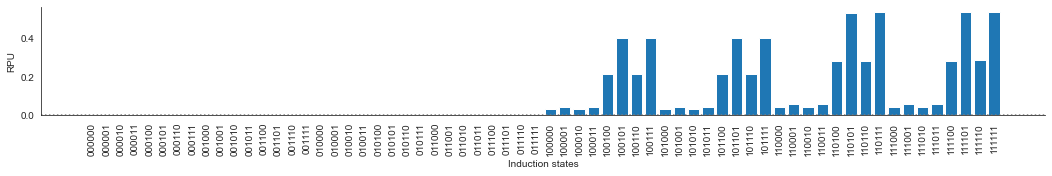

In [83]:
c = candidates[2][-64:]
plt.figure(figsize=[18, 2])
plt.bar(np.arange(64), c)
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('RPU')
plt.xlabel('Induction states')
#plt.yscale('log')
plt.xticks(np.arange(64), [format(x, "06b") for x in np.arange(64)], rotation=90)
#plt.xticklabels(np.arange(64), rotation=90)
print(c[-1], np.log(c[-1]/np.max(c[:-1])))
sns.despine()

0.21585255324031902 0.396335570715033


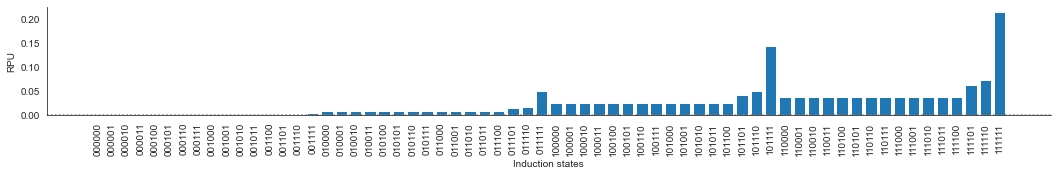

In [65]:
c = candidates[1][-64:]
plt.figure(figsize=[18, 2])
plt.bar(np.arange(64), c)
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('RPU')
plt.xlabel('Induction states')
#plt.yscale('log')
plt.xticks(np.arange(64), [format(x, "06b") for x in np.arange(64)], rotation=90)
#plt.xticklabels(np.arange(64), rotation=90)
print(c[-1], np.log(c[-1]/np.max(c[:-1])))
sns.despine()

0.0004229728376087037 0.0


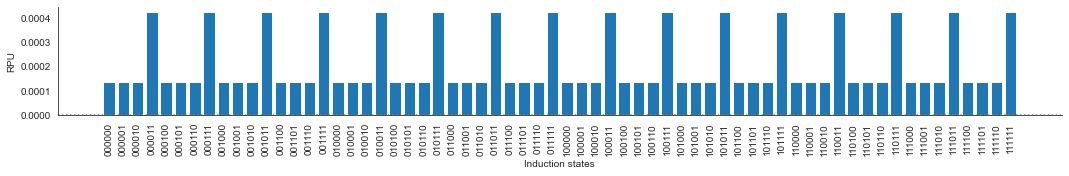

In [75]:
c = candidates[2][-64:]
plt.figure(figsize=[18, 2])
plt.bar(np.arange(64), c)
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('RPU')
plt.xlabel('Induction states')
#plt.yscale('log')
plt.xticks(np.arange(64), [format(x, "06b") for x in np.arange(64)], rotation=90)
#plt.xticklabels(np.arange(64), rotation=90)
print(c[-1], np.log(c[-1]/np.max(c[:-1])))
sns.despine()

In [ ]:
ara_rpu = inducers[0]
cuma_rpu = inducers[2]
states = []
p = [7, 8, 1, 2, 5, 3, 4]
#print([gates[g] for g in p])
for a in range(0, -2, -1):
    for b in range(0, -2, -1):
        for c in range(0, -2, -1):
            for d in range(0, -2, -1):
                
                #circuit_design = circuit_designer(['ara', 'cuma', 'ara', 'cuma'], [gates[g] for g in p])
                #circuit = Circuit(circuit_design, [ara_rpu[a], cuma_rpu[b], ara_rpu[c], cuma_rpu[d]], hill_params)
                #circuit.signal_match()
                #print(a, b, c, d)
                #circuit.print_design()
                
                circuit_design = circuit_designer(['ara', 'cuma', 'ara', 'cuma']*2, [gates[g] for g in p])
                circuit = Circuit(circuit_design, [ara_rpu[a], cuma_rpu[b], ara_rpu[c], cuma_rpu[d]]*2, hill_params)
                circuit.signal_match()
                
                states.append(circuit.get_output())
on = states[-1]
max_off = np.max(states[:-1])
print(p, [gates[g] for g in p], np.log(on/max_off))

In [ ]:
def plot_colormap(fluos, gates, num_row, num_col, ind1, ind2, hill_params):
    
    f, axs = plt.subplots(num_row, num_col, sharex=False, sharey=False, figsize=(num_col*4, num_row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(gates):
            gate = gates[i]
            fluo = fluos[filter(lambda x: x.startswith(gate), fluos.index)]
            
            x1, x2 = np.meshgrid(ind1, ind2)
            x = np.vstack((x1.ravel(), x2.ravel()))
            y = fluo.values
            
            arr_ind1 = np.arange(0, 16.846887772258317, 0.1)
            arr_ind2 = np.arange(0, 16.846887772258317, 0.1)
            x1_, x2_ = np.meshgrid(arr_ind1, arr_ind2)
            x_ = np.vstack((x1_.ravel(), x2_.ravel()))
            y_pred_ = hill_activation_and(x_, *hill_params[gate])
            
            cf = ax.pcolormesh(x2_, x1_, y_pred_.reshape(-1, len(arr_ind1)), cmap='viridis')
            f.colorbar(cf, ax=ax)
            
            if gate=='e42x32STIMPDH1':
                ax.axhline(16.823954609817722, color='red')
                ax.axvline(11.974360213828955, color='red')
            elif gate=='e20x32gp411':
                ax.axhline(7.5950206097534565, color='red')
                ax.axvline(7.543994698752634, color='red')
            elif gate=='e11x32STPhoRadA':
                ax.axhline(0.4073604172225624, color='red')
                ax.axvline(1.878844175166119, color='red')
            
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(gate)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

selection = [5, 3, 0]
selected_gates = [gates[g] for g in selection]
circuit2 = Circuit3(selected_gates, [cuma_rpu[-1], rha_rpu[-1], ohc14_rpu[-1], ara_rpu[-1]])
output = signal_match(circuit2)
plot_colormap(rpus[selection], selected_gates, 1, 3, np.round(cumas_rpu, 2), np.round(aras_rpu, 2), hill_params)

In [ ]:
def plot_colormap(fluos, gates, num_row, num_col, ind1, ind2, hill_params):
    
    f, axs = plt.subplots(num_row, num_col, sharex=False, sharey=False, figsize=(num_col*4, num_row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(gates):
            gate = gates[i]
            fluo = fluos[filter(lambda x: x.startswith(gate), fluos.index)]
            
            x1, x2 = np.meshgrid(ind1, ind2)
            x = np.vstack((x1.ravel(), x2.ravel()))
            y = fluo.values
            
            arr_ind1 = np.arange(0, 16.846887772258317, 0.1)
            arr_ind2 = np.arange(0, 16.846887772258317, 0.1)
            x1_, x2_ = np.meshgrid(arr_ind1, arr_ind2)
            x_ = np.vstack((x1_.ravel(), x2_.ravel()))
            y_pred_ = hill_activation_and(x_, *hill_params[gate])
            
            cf = ax.pcolormesh(x2_, x1_, y_pred_.reshape(-1, len(arr_ind1)), cmap='viridis')
            f.colorbar(cf, ax=ax)
            
            if gate=='e38x32gp418':
                ax.axhline(2.2736487455239915, color='red')
                ax.axvline(1.4844461560653528, color='red')
            elif gate=='e11x32STPhoRadA':
                ax.axhline(7.5950206097534565, color='red')
                ax.axvline(7.543994698752634, color='red')
            elif gate=='e20x32gp411':
                ax.axhline(16.823954609817722, color='red')
                ax.axvline(11.974360213828955, color='red')
            
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(gate)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

selection = [3, 0, 6]
selected_gates = [gates[g] for g in selection]
circuit2 = Circuit3(selected_gates, [ara_rpu[-1], rha_rpu[-1], sal_rpu[-1], ahl_rpu[-1]])
output = signal_match(circuit2)
plot_colormap(rpus[selection], selected_gates, 1, 3, np.round(cumas_rpu, 2), np.round(aras_rpu, 2), hill_params)

In [ ]:
plt.figure(figsize=[8, 2])
plt.bar(np.arange(16), candidates[1])
plt.axhline(0, linestyle='dotted', color='gray')
plt.ylabel('RPU')
plt.xlabel('Induction states')
plt.yscale('log')
plt.xticks(np.arange(16), [format(x, "04b") for x in np.arange(16)], rotation=90)

print(candidates[1][-1]/np.max(candidates[1][:-1]))
#plt.xticklabels(np.arange(64), rotation=90)
sns.despine()

In [ ]:
f, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(4, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i<len(candidates):
        ax.bar(np.arange(16), candidates[i])
        ax.set_ylabel('Fold-change (RPU)')
        ax.set_xlabel('Induction states')
        ax.set_yscale('log')
        ax.set_xticks(np.arange(16))
        ax.set_xticklabels([format(x, "04b") for x in np.arange(16)], rotation=90)
    else:
        ax.set_visible(False)
    sns.despine()
plt.tight_layout()

#### Layering the Gates

In [ ]:
#selected_gates = [4, 0, 3, 5, 2, 6, 1]
[gates[g] for g in result[0][0]]

In [ ]:
#point
fig = plt.figure(figsize=(5, 4))
for i in range(6):
    circuit = Circuit([gates[g] for g in selected_gates], [cumas[i], aras[i]] * 4)
    model = gate_wrapper(fluos.index, circuit, 2)
    pd.Series(model[13], index=fluos.index/60, name='cuma={}, ara={}'.format(cumas[i], aras[i])).plot()
plt.legend()
sns.despine()

In [ ]:
#interval
fig = plt.figure(figsize=(5, 4))
for i in range(6):
    circuit2 = Circuit([gates[g] for g in result[0][0]], [cumas[i], aras[i]] * 4)
    model = gate_wrapper(fluos.index, circuit2, 2)
    pd.Series(model[13], index=fluos.index/60, name='cuma={}, ara={}'.format(cumas[i], aras[i])).plot()
plt.legend()
sns.despine()

In [ ]:
circuit1 = Circuit([gates[g] for g in selected_gates], [cumas[5], aras[5]] * 4)
model = gate_wrapper(fluos.index, circuit1, 2)
for i, m in enumerate(model):
    if i%2==0:
        pd.Series(m, index=fluos.index/60, name=i).plot()
plt.legend()
sns.despine()

In [ ]:
circuit2 = Circuit2([gates[g] for g in result[0][0]], [cumas[5], aras[5]] * 4)
signal_match(circuit2)

In [ ]:
circuit2 = Circuit2([gates[g] for g in result[0][0]], [cumas[1], aras[1]] * 4)
signal_match(circuit2)

In [ ]:
cumas_rpu, aras_rpu

In [ ]:
circuit2 = Circuit2([gates[g] for g in [0, 2, 3, 8, 5, 6, 7]], [cumas_rpu[4], aras_rpu[4]] * 4)
signal_match(circuit2)

In [ ]:
circuit2 = Circuit2([gates[g] for g in [1, 2, 3, 4, 5, 6, 7]], [cumas_rpu[5], aras_rpu[5]] * 4)
signal_match(circuit2)

In [ ]:
def initialPopulation(pop_size, num_indiv, length):
    population = []
    arrangement = np.arange(num_indiv)
    for i in range(pop_size):
        new_arrangement = [i for i in arrangement]
        np.random.shuffle(new_arrangement)
        population.append(new_arrangement[:length])
    return np.array(population)

def calculateFitness(pop):
    
    f_t = fluos.index
    fitness = []
    
    for i, p in enumerate(pop):
        #circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, p)
        #model = gate_wrapper2(f_t, circuit)
        #gfp = pd.Series(model[33], index=f_t/60)
        
        circuit = Circuit(gates[:7], [cumas[5], aras[5]] * 4)
        #model = gate_wrapper(fluos.index, circuit, 2)
        #gfp = pd.Series(model[13], index=fluos.index/60)
        #fitness.append(gfp.max()-gfp.min())
        gfp = signal_match(circuit)
        fitness.append(gfp)
    return np.array(fitness)

def rankIndiv(population):
    
    fitness = calculateFitness(population)
    fitnessResults = [(a, b) for a, b in zip(population, fitness)]
    return np.array(sorted(fitnessResults, key=lambda x: x[1], reverse=True))

def selection(popRanked, eliteSize):
    
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        selected = selectionResults[i]
        matingpool.append(selected)
    return matingpool

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    
    return child

def breedPopulation(matingpool, eliteSize, length):
    
    children = []
    nonElite = len(matingpool) - eliteSize
    pool = random.choices(matingpool, k=len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, nonElite):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child[:length])
    
    return np.array(children)

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return np.array(mutatedPop)

def nextGeneration(currentGen, eliteSize, mutationRate, length):
    
    popRanked = rankIndiv(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize, length)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, candidates, length):
    pop = initialPopulation(popSize, candidates, length)
    pop_copy = [i for i in pop]
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
    return pop_copy, rankIndiv(pop)

pop_copy, result = geneticAlgorithm(popSize=100, eliteSize=20, mutationRate=0.01, generations=20, candidates=len(gates), length=7)
result

In [ ]:
#hill function
fig = plt.figure(figsize=(5, 4))
for i in range(6):
    circuit2 = Circuit([gates[g] for g in [1, 2, 3, 4, 5, 6, 7]], [cumas[i], aras[i]] * 4)
    model = gate_wrapper(fluos.index, circuit2, 2)
    pd.Series(model[13], index=fluos.index/60, name='cuma={}, ara={}'.format(cumas[i], aras[i])).plot()
plt.legend()
sns.despine()

### Exhaustive Search

In [ ]:
gate_params_selected = [par['Value'] for par in f_df_deg]
all_arr = [list(a) for a in list(itertools.permutations(np.arange(len(gate_params_selected)), 7))]
len(all_arr)

In [ ]:
gate_params_selected = [par['Value'] for par in f_df_deg]
#arr = np.arange(len(gate_params_selected))
#np.random.shuffle(arr)
#print(arr)
f_t = fluo_selected.index

results = []
for i, arr in enumerate(tqdm(all_arr)):
    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, arr)
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    dyn = gfp.max() - gfp.min()
    results.append((dyn, arr))

In [ ]:
best_results = sorted(results, reverse=True)[:10]
print('Best result', best_results[0][0])
for i, res in enumerate(tqdm(best_results)):
    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, res[1])
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    plt.plot(gfp, label= res[1])
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
sns.despine()
plt.show()

In [ ]:
gate_params_selected = [par['Value'] for par in f_df_deg]
ga_arrangement = result[0][0]
print(ga_arrangement)

f_t = fluo_selected.index
for ar in pop_copy[:1]:

    circuit = Circuit(fluo_selected, od_selected, gate_params_selected, od_params_selected, None, ga_arrangement)
    model = gate_wrapper2(f_t, circuit)
    gfp = pd.Series(model[33], index=f_t/60)
    print(gfp.max()-gfp.min())
    plt.plot(gfp, label=ga_arrangement)
plt.legend(bbox_to_anchor=(1.05, 1), ncol=2)
sns.despine()
plt.show()

In [ ]:
final_asg = fluo_selected[[fluo_selected.columns[j] for j in ga_arrangement]]
num_col = 7
num_row = 1
f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < num_traces:
        ax.plot(final_asg.index / 60, final_asg.iloc[:, i])
        ax.set_title(final_asg.columns[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
def geneticAlgorithmPlot(pop_copy, popSize, eliteSize, mutationRate, generations, candidates, length):
    pop = [i for i in pop_copy]
    progress = []
    progress.append(rankIndiv(pop)[0][1])
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate, length)
        progress.append(rankIndiv(pop)[0][1])
    return progress
    
progress = geneticAlgorithmPlot(pop_copy, popSize=100, eliteSize=20, mutationRate=0.01, generations=20, candidates=len(selected), length=7)
plt.figure(figsize=[6, 4])
plt.plot(progress[:20])
plt.ylabel('Dynamic Range')
plt.xlabel('Generation')
sns.despine()
plt.show()

In [ ]:
circuit = Circuit(gates[:7], [cumas[2], aras[2]] * 4)
model = gate_wrapper(fluos.index, circuit, 2)
gfp = pd.Series(model[13], index=fluos.index/60)

In [11]:
def fitness (individual, data):
    fitness = 0
    if individual.count(1) == 2:
        for (selected, (fruit, profit)) in zip(individual, data):
            if selected:
                fitness += profit
    return fitness

data = [('pear', 50), ('apple', 35), ('banana', 40)]
ga = pyeasyga.GeneticAlgorithm(data)
ga.fitness_function = fitness
ga.run()
ga.best_individual()

(90, [1, 0, 1])

In [13]:
[random.randint(0, 9) for _ in range(len(data))]

[1, 8, 9]

In [14]:
def create_individual(data):
    return [random.randint(0, 1) for _ in range(len(data))]

def fitness (individual, data):
    fitness = 0
    if individual.count(1) == 1:
        for (selected, (fruit, profit)) in zip(individual, data):
            if selected:
                fitness += profit
    return fitness

def crossover(parent_1, parent_2):
    index = random.randrange(1, len(parent_1))
    child_1 = parent_1[:index] + parent_2[index:]
    child_2 = parent_2[:index] + parent_1[index:]
    return child_1, child_2

def mutate(individual):
    mutate_index = random.randrange(len(individual))
    if individual[mutate_index] == 0:
        individual[mutate_index] = 1
    else:
        individual[mutate_index] = 0
        
def selection(population):
    return random.choice(population)

In [16]:
data = [('pear', 50), ('apple', 35), ('banana', 40)]
ga = pyeasyga.GeneticAlgorithm(data,
                               population_size=10,
                               generations=20,
                               crossover_probability=0.8,
                               mutation_probability=0.05,
                               elitism=True,
                               maximise_fitness=True)

ga.create_individual = create_individual
ga.crossover_function = crossover
ga.mutate_function = mutate
ga.selection_function = selection
ga.fitness_function = fitness
ga.run()
ga.best_individual()

(50, [1, 0, 0])

In [48]:
# setup data
data = [(821, 0.8, 118), (1144, 1, 322), (634, 0.7, 166), (701, 0.9, 195),
        (291, 0.9, 100), (1702, 0.8, 142), (1633, 0.7, 100), (1086, 0.6, 145),
        (124, 0.6, 100), (718, 0.9, 208), (976, 0.6, 100), (1438, 0.7, 312),
        (910, 1, 198), (148, 0.7, 171), (1636, 0.9, 117), (237, 0.6, 100),
        (771, 0.9, 329), (604, 0.6, 391), (1078, 0.6, 100), (640, 0.8, 120),
        (1510, 1, 188), (741, 0.6, 271), (1358, 0.9, 334), (1682, 0.7, 153),
        (993, 0.7, 130), (99, 0.7, 100), (1068, 0.8, 154), (1669, 1, 289)]

ga = pyeasyga.GeneticAlgorithm(data)        # initialise the GA with data
ga.population_size = 200                    # increase population size to 200 (default value is 50)

# define a fitness function
def fitness(individual, data):
    print(individual)
    weight, volume, price = 0, 0, 0
    for (selected, item) in zip(individual, data):
        if selected:
            weight += item[0]
            volume += item[1]
            price += item[2]
    if weight > 12210 or volume > 12:
        price = 0
    return price

ga.fitness_function = fitness               # set the GA's fitness function
ga.run()                                    # run the GA
ga.best_individual()                  # print the GA's best solution

[1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]
[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]
[0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1]
[0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
[1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0

[0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]
[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]
[0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]
[0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1]
[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1

(3465,
 [0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1])